# **Pairing Averaged**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import Materials_Parameters as mp
from MTI_Discretization import eigenstates_Dirichlet as eigenstates
from MTI_Second_Order import FMTI2_NeumannBC, Change_Basis, Block_Reverse

# parameters
d = 100.; mu = 0.010; Delta = 0.005; L = 0.010
# coupling matrices        f = 0.
Gamma = np.matrix([[1,0],[0,1],[1,0],[0,1]])

## Zero Magnetization $\Lambda = 0$ meV

#### **Energy Spectrum**

In [2]:
# lattice
Nlat = 100; d = 100.; dZ = d/(Nlat-1)

egval = []
momentum = np.linspace(-0.15, 0.15, 101)

for k in momentum:
    
    # eigenstates
    lattice, egv, spinors = eigenstates(Nlat=Nlat, dZ=dZ, kx = k, ky = 0., L = 0.)

    egval.append(np.sort(egv))

egval = np.array(egval)

print(egval.shape)

(101, 400)


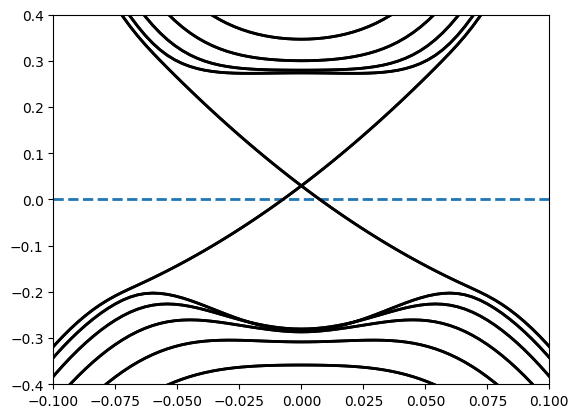

In [16]:
fig, ax = plt.subplots(1)

ax.axhline(0, ls='--', lw=2)


n = 50
for idx in range(n):

    iegv = 200 - int(n/2) + idx 
    
    ax.plot(momentum, egval[:,iegv], c='black', lw=2)


ax.set_xlim(-0.1,0.1);
ax.set_ylim(-0.4,0.4);

#### **Induced Pairing**

In [4]:
# shape of the matrix 
n = 4

# space dimensions
K = []; Z = []
k_dim = 100; z_dim = 100

# read file pairing
rows = np.loadtxt("Pairing/pairing_L-0.txt")

# store data in matrices
F_data = np.empty((k_dim, z_dim, 4, 4), dtype='complex')


# loop over momenta
for idx in range(k_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: K.append(float(row[0]))
    
        if idx == 0: Z.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_data[idx][jdx] = Change_Basis(matrix)

print(F_data.shape)

(100, 100, 4, 4)


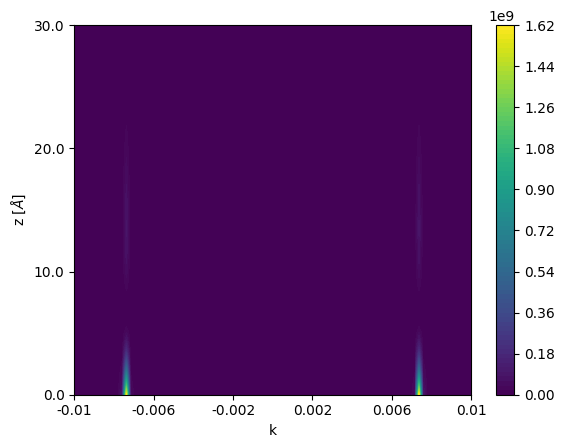

In [5]:
# norm of the induced pairing
F = np.linalg.norm(F_data, axis=(2,3))

contour = plt.contourf(F.T, levels=100)
plt.colorbar(contour)

y_ticks = np.linspace(0, len(Z)-1, 4)
y_labels = np.linspace(Z[0], Z[-1], 4)

x_ticks = np.linspace(0, len(K)-1, 6)
x_labels = np.linspace(K[0], K[-1], 6)


plt.xticks(x_ticks, x_labels);
plt.yticks(y_ticks, y_labels);

plt.xlabel('k')
plt.ylabel('z [$\AA$]');

### **Spin Symmetry**

In [6]:
# swap spin only
F_swap = np.array([[Block_Reverse(f) for f in F1] for F1 in F_data])

# matrices for signlet
F_singlet = 0.5*(F_data - F_swap)
# matrices for triplet
F_triplet = 0.5*(F_data + F_swap)

fs = np.linalg.norm(F_singlet, axis=(2, 3))
ft = np.linalg.norm(F_triplet, axis=(2, 3))
norm = np.max(fs+ft)

print(fs.shape, ft.shape)

(100, 100) (100, 100)


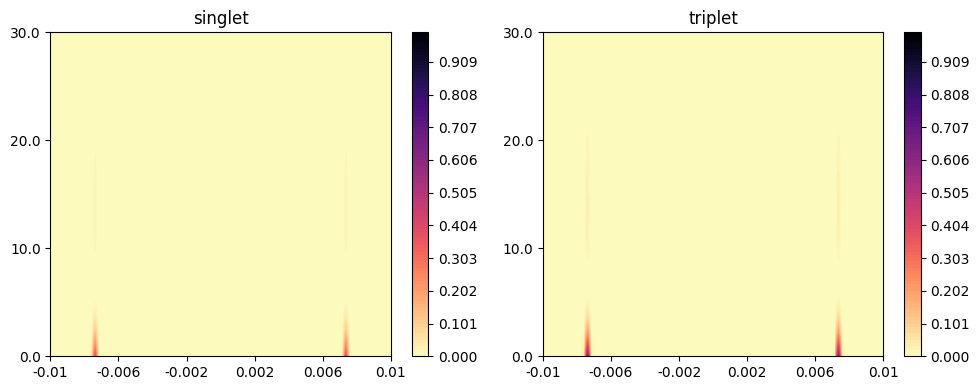

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First contour plot
c1 = axes[0].contourf(fs.T/norm, levels=np.linspace(0,1, 100),  cmap='magma_r', vmin=0, vmax=1)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('singlet')

# Second contour plot
c2 = axes[1].contourf(ft.T/norm, levels=np.linspace(0,1, 100), cmap='magma_r', vmin=0, vmax=1)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('triplet')

for ax in axes:
    ax.set_xticks(x_ticks, x_labels);
    ax.set_yticks(y_ticks, y_labels);


plt.tight_layout()
plt.show()

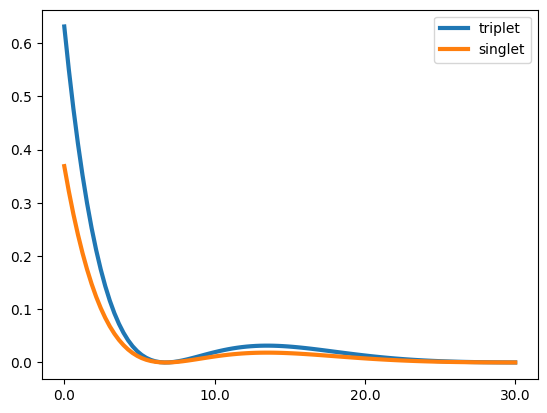

In [8]:
norm = np.sum(fs+ft, axis=0)[0]

plt.plot(np.sum(ft, axis=0)/norm, lw=3, label='triplet')
plt.plot(np.sum(fs, axis=0)/norm, lw=3, label='singlet')

plt.xticks(y_ticks, y_labels);
plt.legend();

#### **Triplet Components**

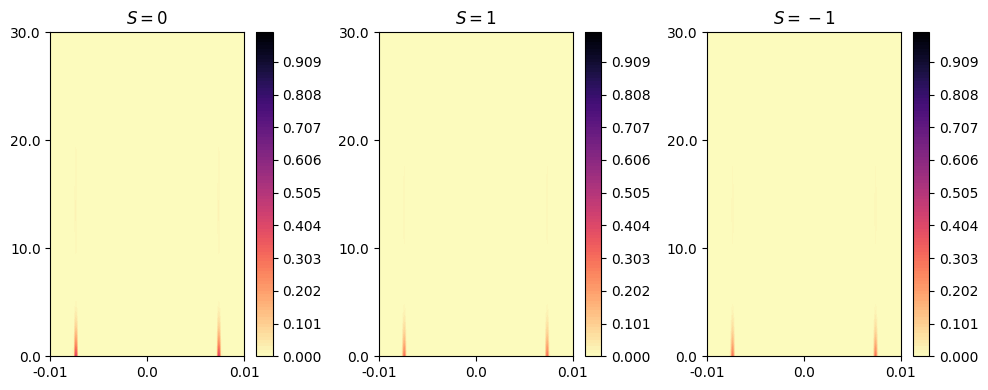

In [9]:
# spin S=0 part
F0 = F_triplet[:, :, 0:2, 0:2]; f0 = np.sqrt(2)*np.linalg.norm(F0, axis=(2, 3))
# spin S=1 part
Fp1 = F_triplet[:, :, 0:2, 0:2]; fp1 = np.linalg.norm(Fp1, axis=(2, 3))
# spin S=-1 part
Fm1 = F_triplet[:, :, 2:4, 2:4]; fm1 = np.linalg.norm(Fm1, axis=(2, 3))

norm = np.max(f0+fp1+fm1)

fig, axes = plt.subplots(1, 3, figsize=(10, 4))  # 1 row, 2 columns

# First contour plot
c1 = axes[0].contourf(f0.T/norm, cmap='magma_r', levels=np.linspace(0,1, 100),)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('$S=0$')

# Second contour plot
c2 = axes[1].contourf(fp1.T/norm, cmap='magma_r', levels=np.linspace(0,1, 100),)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('$S=1$')

# Third contour plot
c3 = axes[2].contourf(fm1.T/norm, cmap='magma_r', levels=np.linspace(0,1, 100),)
fig.colorbar(c3, ax=axes[2])
axes[2].set_title('$S=-1$')


x_ticks = np.linspace(0, len(K)-1, 3)
x_labels = np.linspace(K[0], K[-1], 3)

for ax in axes:
    ax.set_xticks(x_ticks, x_labels);
    ax.set_yticks(y_ticks, y_labels);
    
plt.tight_layout()
plt.show()

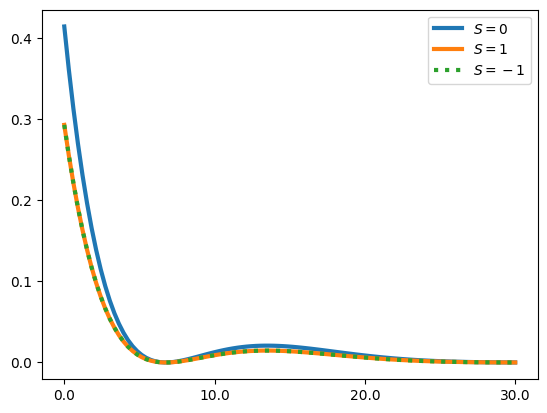

In [10]:
norm = np.sum(f0+fp1+fm1, axis=0)[0]

plt.plot(np.sum(f0, axis=0)/norm, lw=3, label='$S=0$')
plt.plot(np.sum(fp1, axis=0)/norm, lw=3, label='$S=1$')
plt.plot(np.sum(fm1, axis=0)/norm, lw=3, label='$S=-1$', ls=':')

plt.xticks(y_ticks, y_labels);

plt.legend();

### **Momentum Symmetry**

In [11]:
# reverse momentum
F_krev = F_data[::-1, :, :, :]

# matrices for even components
F_even = 0.5*(F_data + F_krev)
# matrices for odd components
F_odd = 0.5*(F_data - F_krev)

fe = np.linalg.norm(F_even, axis=(2, 3))
fo = np.linalg.norm(F_odd, axis=(2, 3))
norm = np.max(fe+fo)

print(fs.shape, ft.shape)

(100, 100) (100, 100)


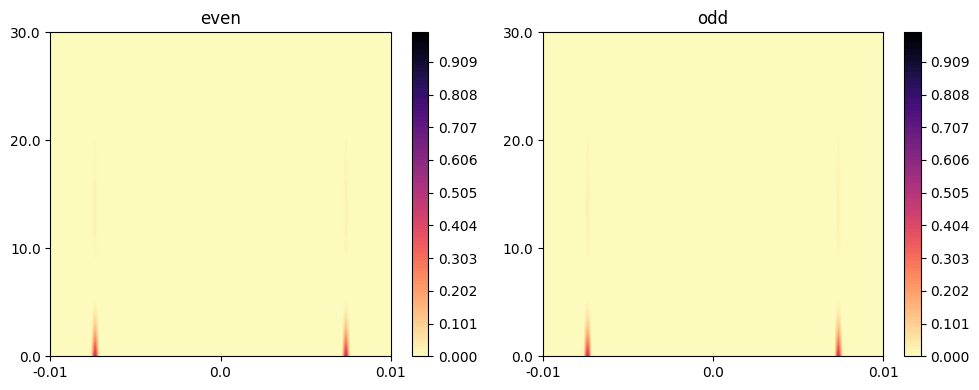

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First contour plot
c1 = axes[0].contourf(fe.T/norm, levels=np.linspace(0,1, 100),  cmap='magma_r', vmin=0, vmax=1)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('even')

# Second contour plot
c2 = axes[1].contourf(fo.T/norm, levels=np.linspace(0,1, 100), cmap='magma_r', vmin=0, vmax=1)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('odd')


for ax in axes:
    ax.set_xticks(x_ticks, x_labels);
    ax.set_yticks(y_ticks, y_labels);


plt.tight_layout()
plt.show()

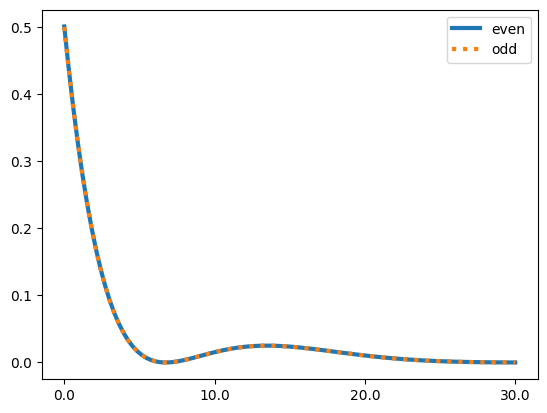

In [13]:
norm = np.sum(fe+fo, axis=0)[0]

plt.plot(np.sum(fe, axis=0)/norm, lw=3, label='even')
plt.plot(np.sum(fo, axis=0)/norm, lw=3, label='odd', ls=':')

plt.xticks(y_ticks, y_labels);
plt.legend();